<a href="https://colab.research.google.com/github/csapp0903/RL_Test_01/blob/main/dqn_cartpole_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Test 01: DQN CartPole (PyTorch)

这是一个使用 Deep Q-Network (DQN) 解决 CartPole-v1 问题的完整示例。
本 Notebook 包含环境安装、模型定义、训练循环以及详细的结果可视化。

**可以直接在 Google Colab 中点击运行。**

In [2]:
# 1. 安装依赖 (适配 Google Colab 环境)
import sys
import subprocess

print("正在检查并安装依赖环境...")
!pip install gymnasium[classic_control] matplotlib torch numpy
print("依赖安装完成！")

正在检查并安装依赖环境...
依赖安装完成！


In [3]:
# 2. 导入库与环境设置
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 设置 matplotlib 在 notebook 中直接显示
%matplotlib inline

# 检测 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用计算设备: {device}")

使用计算设备: cpu


In [4]:
# 3. 超参数配置
BATCH_SIZE = 128        # 批量大小
GAMMA = 0.99            # 折扣因子
EPS_START = 0.9         # 初始探索率
EPS_END = 0.05          # 最小探索率
EPS_DECAY = 1000        # 探索率衰减速率
TAU = 0.005             # 目标网络软更新系数
LR = 1e-4               # 学习率
MEMORY_CAPACITY = 10000 # 经验回放池容量
EPISODES = 300          # 训练总回合数

In [5]:
# 4. 定义核心类：经验回放池与神经网络

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward, done):
        """保存一条经验"""
        self.memory.append((state, action, next_state, reward, done))

    def sample(self, batch_size):
        """随机采样"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
# 5. 辅助函数：动作选择与模型优化

steps_done = 0

def select_action(state, policy_net, env):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample < eps_threshold:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)

def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return None

    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

    state_batch = torch.cat(batch_state)
    action_batch = torch.cat(batch_action)
    reward_batch = torch.cat(batch_reward)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch_next_state if s is not None])

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss.item()

In [7]:
# 6. 训练主循环

env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_CAPACITY)

episode_rewards = []
episode_losses = []

print(f"开始训练 {EPISODES} 个回合...")
print("-" * 50)

for i_episode in range(EPISODES):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0
    losses = []

    for t in count():
        action = select_action(state, policy_net, env)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        reward_tensor = torch.tensor([reward], device=device)
        total_reward += reward
        memory.push(state, action, next_state, reward_tensor, done)
        state = next_state

        loss_val = optimize_model(memory, policy_net, target_net, optimizer)
        if loss_val is not None:
            losses.append(loss_val)

        # 软更新目标网络
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    episode_rewards.append(total_reward)
    episode_losses.append(np.mean(losses) if losses else 0)

    if (i_episode + 1) % 20 == 0:
        print(f"Episode {i_episode + 1}/{EPISODES} | Reward: {total_reward:.1f} | Avg Loss: {episode_losses[-1]:.4f}")

print("训练结束！")
torch.save(policy_net.state_dict(), "cartpole_dqn.pth")

开始训练 300 个回合...
--------------------------------------------------
Episode 20/300 | Reward: 14.0 | Avg Loss: 0.0784
Episode 40/300 | Reward: 10.0 | Avg Loss: 0.0542
Episode 60/300 | Reward: 14.0 | Avg Loss: 0.1134
Episode 80/300 | Reward: 10.0 | Avg Loss: 0.1670
Episode 100/300 | Reward: 12.0 | Avg Loss: 0.2421
Episode 120/300 | Reward: 18.0 | Avg Loss: 0.3189
Episode 140/300 | Reward: 12.0 | Avg Loss: 0.3742
Episode 160/300 | Reward: 17.0 | Avg Loss: 0.4806
Episode 180/300 | Reward: 24.0 | Avg Loss: 0.5023
Episode 200/300 | Reward: 62.0 | Avg Loss: 0.5951
Episode 220/300 | Reward: 70.0 | Avg Loss: 0.6768
Episode 240/300 | Reward: 62.0 | Avg Loss: 0.7649
Episode 260/300 | Reward: 51.0 | Avg Loss: 0.8128
Episode 280/300 | Reward: 51.0 | Avg Loss: 0.9299
Episode 300/300 | Reward: 81.0 | Avg Loss: 0.9039
训练结束！


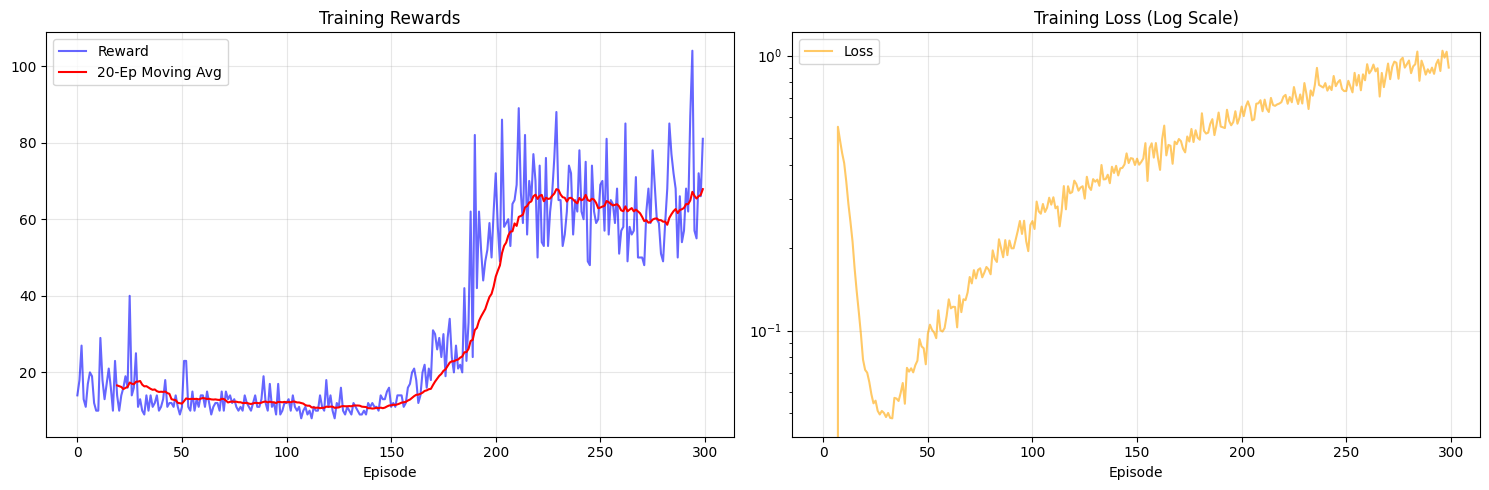

In [8]:
# 7. 结果可视化
def plot_results(rewards, losses):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rewards, label='Reward', color='blue', alpha=0.6)
    # 移动平均线
    window = 20
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), moving_avg, label='20-Ep Moving Avg', color='red')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(losses, label='Loss', color='orange', alpha=0.6)
    plt.title('Training Loss (Log Scale)')
    plt.xlabel('Episode')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_results(episode_rewards, episode_losses)